## Kuro Siwo dataset exploration

This notebook showcases the data included in Kuro Siwo and provides visualised examples of different samples.

We assume that this notebook is run from inside the [Kuro Siwo repository](https://github.com/Orion-AI-Lab/KuroSiwo) and that the dataset, along with the pickle and JSON files with the train/val/test splits, have been downloaded inside a particular folder of the user's choice.

First, let's import the required modules:

In [1]:
import pyjson5 as json
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl

from utilities.utilities import prepare_loaders, update_config, reverse_scale_img

/u/mp005/.conda/envs/myproj310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sanity
import os
print("CUDA avail?", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

CUDA avail? False
GPU: None


### Configuration files

An important part of the Kuro Siwo implementation is the configuration files. There are several different files, all residing inside the `configs` folder:

 - **augmentations/** contains configurations for the data augmentations during training
 - **loss/** contains specific configurations for some loss functions
 - **method/** contains configurations for the particular model to be run
 - **train/** contains configurations focused on the training setup and the data to be used
 - **config.json** contains generic configuration parameters for the whole pipeline
 
Let's open the `config.json` file and see its contents:

In [3]:
configs = json.load(open("configs/config.json", "r"))
configs

{'task': 'segmentation',
 'root_path': 'KuroSiwo/',
 'wandb_project': 'Your_Project',
 'wandb_entity': 'your_entity',
 'wandb_id': 'None',
 'resume_wandb': False,
 'wandb_activate': False,
 'log_AOI_metrics': True,
 'log_zone_metrics': False,
 'method': 'unet',
 'gpu': 0,
 'mixed_precision': True,
 'num_classes': 3,
 'test': False}

Let's explain some of the parameters:

 - `task`: can be either `segmentation`, `cd` for change detection, or `mae` for Masked Autoencoder
 - `root_path`: the path containing the dataset
 - `method`: the model to be used
 - `gpu`: the GPU id to be used
 - `num_classes`: the number of classes. Here we use 3: no water, permanent water, flood
 - `test`: of true, then the model runs in inference mode. Otherwise, the model runs in training mode
 
Let's update the `root_path` with the folder containing Kuro Siwo:

In [4]:
configs['root_path'] = '/ptmp/mp005/KuroSiwo/'
# configs['root_path'] = '/ptmp/mp002/ellis/Kuro-Siwo/'

 Now, the other most important configuration files reside inside the **configs/train/** folder. Let's open them to see their contents:

In [5]:
data_configs = json.load(open("configs/train/data_config.json", "r"))
data_configs

{'track': 'RandomEvents',
 'train_pickle': 'pickle/KuroV2_grid_dict.gz',
 'test_pickle': 'pickle/KuroV2_grid_dict_test_0_100.gz',
 'negative_pickle': None,
 'slc': False,
 'train_json': 'json/slc_grid_pwater_0.0001.json',
 'test_json': 'json/slc_grid_pwater_0.json',
 'slc_root_path': '',
 'inputs': ['pre_event_1', 'pre_event_2', 'post_event'],
 'channels': ['vv', 'vh'],
 'water_percentage': '[0,100]',
 'data_augmentations': False,
 'clamp_input': 0.15,
 'scale_input': 'normalize',
 'data_mean': [0.0953, 0.0264],
 'data_std': [0.0427, 0.0215],
 'dem_mean': 93.4313,
 'dem_std': 1410.8382,
 'slc_dem_mean': 82.96274925580951,
 'slc_dem_std': 153.71243439980663,
 'slc_mean': [0.022367, 39.242, 81.13, 0.043526],
 'slc_std': [1.2843, 25.6152, 58.0151, 1.2844],
 'dem': False,
 'slope': False,
 'slope_mean': 2.1277,
 'slope_std': 67.5048,
 'slc_slope_mean': 0.3977,
 'slc_slope_std': 0.4946,
 'reverse_scaling': False,
 'uint8': False,
 'train_acts': [130,
  470,
  555,
  118,
  174,
  324,
  421

Let's explain some of the parameters:

 - `track`: this should always be "RandomEvents"
 - `train_pickle`: the path of the pickle file for the train split of the GRD data
 - `test_pickle`: the path of the pickle file for the test split of the GRD data
 - `slope_path`: the path of the precomputed slopes (optional. If not given slope is computed on the fly)
 - `slc`: if True, then SLC data are used. Otherwise, GRD data are used.
 - `train_json`: the path of the JSON file for the train split of SLC data
 - `test_json`: the path of the JSON file for the test split of SLC data 
 - `slc_root_path`: the path containing the SLC data
 - `inputs`: a list containing at least one of the following: "pre_event_1", "pre_event_2", "post_event"
 - `channels`: a list containing at least one of the following: "vv", "vh"
 - `data_augmentations`: if true, then data augmentations are used during training
 - `dem`: if true, then DEM data are also used
 - `slope`: if true, then slope data are also used

In [6]:
train_configs = json.load(open("configs/train/train_config.json", "r"))
train_configs

{'batch_size': 128,
 'epochs': 1,
 'num_workers': 8,
 'start_epoch': 0,
 'print_frequency': 10,
 'on_screen_prints': False,
 'train_save_checkpoint_freq': 1,
 'weighted': False,
 'resume_checkpoint': False,
 'loss_function': 'cross_entropy',
 'oversampling': False,
 'evaluate_water': True}

Let's explain some of the parameters:

 - `batch_size`: the size of the batch
 - `epochs`: the number of training epochs
 - `num_workers`: the number of workers to be used for the dataset
 - `print_frequency`: the number of epochs after which to print informative messages
 - `on_screen_prints`: if true, then informative messages are printed on the screen
 - `train_save_checkpoint_freq`: the number of epochs after which to save a model checkpoint
 - `weighted`: if true, then weighted loss is used
 - `resume_checkpoint`: if true, then training resumes from the checkpoint given by `eval_checkpoint`
 - `loss_function`: the loss function to be used
 - `evaluate_water`: if true, then an additional metric is computed for water and no water classes
 - `eval_checkpoint`: if given a path, then training resumes from the checkpoint in that path
 
 The `configs` dictionary must include all this information. We provide a function that reads all the required config files and updates the dictionary:

In [7]:
configs = update_config(configs, None)

train activations  27
val activations  7
test activations  10
Configs updated


In [8]:
configs['train_pickle'] = '/u/mp005/challenge/KuroSiwo/pickle/KuroV2_grid_dict.pkl'
configs['test_pickle'] = '/u/mp005/challenge/KuroSiwo/pickle/KuroV2_grid_dict_test_0_100.pkl'

### GRD Data loaders

#### With DEM

Now let's initialise the data loaders. For our first example we will use GRD with DEM data, so we will update the `configs` dictionary accordingly.

In [10]:
configs['dem'] = True
configs['slope'] = False
configs['slc'] = False
train_loader, val_loader, test_loader = prepare_loaders(configs)

Initializing  RandomEvents
(train) Using precalculated stats for dataset...
Samples per Climatic zone for mode:  train
{1: 3176, 2: 1400, 3: 16886}
Samples per Activation for mode:  train
{118: 108, 130: 248, 147: 362, 174: 26, 267: 218, 273: 112, 275: 742, 324: 189, 417: 162, 421: 68, 427: 1980, 470: 376, 492: 213, 496: 21, 497: 398, 498: 102, 502: 445, 518: 306, 554: 71, 555: 684, 567: 96, 1111004: 4086, 1111005: 620, 1111006: 313, 1111009: 7556, 1111010: 341, 1111011: 1619}
(val) Using precalculated stats for dataset...
Samples per Climatic zone for mode:  val
{1: 165, 2: 2400, 3: 261}
Samples per Activation for mode:  val
{279: 2381, 437: 169, 520: 92, 559: 42, 1111003: 19, 1111008: 123}
(test) Using precalculated stats for dataset...
Samples per Climatic zone for mode:  test
{1: 4696, 2: 1085, 3: 10115}
Samples per Activation for mode:  test
{205: 130, 277: 1834, 321: 432, 411: 149, 445: 361, 561: 69, 562: 77, 1111002: 32, 1111007: 4134, 1111013: 8678}
Samples in Train Set:  21462

When initialising the dataloaders for the first time, a `stats.pkl` file is produced which contains the minimum and maximum values of the dataset, useful for scaling data later on.

In the screen prints we can also see the number of samples per Climatic Zone and per AOI for each set.

#### Sample visualization

Let's visualize a sample from the train set.

In [11]:
batch = train_loader.dataset.__getitem__(0)

In [12]:
post_scale_var_1, post_scale_var_2, post_event, mask, pre1_scale_var_1, \
pre1_scale_var_2, pre_event_1, pre2_scale_var_1, pre2_scale_var_2, pre_event_2, dem, clz, activ = batch

Each batch contains the following data:
 - `post_scale_var_1`, `post_scale_var_2`: the variables used for scaling the post-flood image (useful for reverse scaling afterwards, if needed)
 - `post_event`: the post-flood image
 - `mask`: the ground truth mask
 - `pre1_scale_var_1`, `pre1_scale_var_2`:  the variables used for scaling the first pre-flood image (useful for reverse scaling afterwards, if needed)
 - `pre_event_1`: the first pre-flood image
 - `pre2_scale_var_1`, `pre2_scale_var_2`:  the variables used for scaling the second pre-flood image (useful for reverse scaling afterwards, if needed)
 - `pre_event_2`: the second pre-flood image
 - `dem`: the DEM
 - `clz`: an integer depicting the climate zone of the sample
 - `activ`: an integer depicting the activation ID of the sample
 
Note that we had defined `data_configs['inputs'] = ['pre_event_1', 'pre_event_2', 'post_event']`, therefore the dataloader returns all three images of the sample.

We have also defined `data_configs['channels'] = ['vv', 'vh']`, therefore each image contains two channels: VV and VH.

In [13]:
post_event.shape

torch.Size([2, 224, 224])

Now let's visualise the images in this sample.

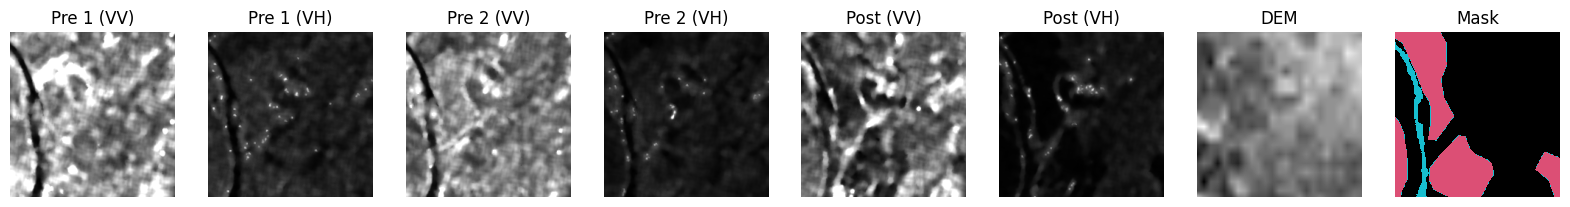

In [14]:
fig, ax = plt.subplots(1, 8, figsize=(20, 8))

cmap =  mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', [(0, 0, 0, 10), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), (0.8647058823529412, 0.30980392156862746, 0.45882352941176474, 1.0), (0.918, 0.929, 0.361, 1.0)], 4)

# First pre-image
img = reverse_scale_img(pre_event_1, torch.tensor(pre1_scale_var_1), torch.tensor(pre1_scale_var_2), configs)
ax[0].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[1].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[0].set_title('Pre 1 (VV)')
ax[1].set_title('Pre 1 (VH)')

# Second pre-image
img = reverse_scale_img(pre_event_2, torch.tensor(pre2_scale_var_1), torch.tensor(pre2_scale_var_2), configs)
ax[2].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[3].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[2].set_title('Pre 2 (VV)')
ax[3].set_title('Pre 2 (VH)')

# Post-image
img = reverse_scale_img(post_event, torch.tensor(post_scale_var_1), torch.tensor(post_scale_var_2), configs)
ax[4].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[5].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[4].set_title('Post (VV)')
ax[5].set_title('Post (VH)')

# DEM
img = dem
ax[6].imshow(img.squeeze().cpu().numpy(), cmap='gray')
ax[6].set_title('DEM')

# Mask
img = mask
ax[7].imshow(img.squeeze().cpu().numpy(), cmap=cmap, vmin=0, vmax=3)
ax[7].set_title('Mask')

for i in range(8):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines[['top', 'bottom', 'left', 'right']].set_visible(False)

plt.show()

The class labels in the mask follow this scheme:
 - `0`: 'No water'  (black)
 - `1`: 'Permanent Waters'  (blue)
 - `2`: 'Floods'  (red)
 - `3`: 'Invalid pixels'  (yellow)

Now let's see how the slope information looks like. For this, we have to set the parameter `data_configs['slope'] = true` and initialise different dataloaders.

In [15]:
configs['dem'] = True
configs['slope'] = True
configs['slope_path'] = None
configs['slc'] = False
train_loader, val_loader, test_loader = prepare_loaders(configs)

Initializing  RandomEvents
(train) Using precalculated stats for dataset...
Samples per Climatic zone for mode:  train
{1: 3176, 2: 1400, 3: 16886}
Samples per Activation for mode:  train
{118: 108, 130: 248, 147: 362, 174: 26, 267: 218, 273: 112, 275: 742, 324: 189, 417: 162, 421: 68, 427: 1980, 470: 376, 492: 213, 496: 21, 497: 398, 498: 102, 502: 445, 518: 306, 554: 71, 555: 684, 567: 96, 1111004: 4086, 1111005: 620, 1111006: 313, 1111009: 7556, 1111010: 341, 1111011: 1619}
(val) Using precalculated stats for dataset...
Samples per Climatic zone for mode:  val
{1: 165, 2: 2400, 3: 261}
Samples per Activation for mode:  val
{279: 2381, 437: 169, 520: 92, 559: 42, 1111003: 19, 1111008: 123}
(test) Using precalculated stats for dataset...
Samples per Climatic zone for mode:  test
{1: 4696, 2: 1085, 3: 10115}
Samples per Activation for mode:  test
{205: 130, 277: 1834, 321: 432, 411: 149, 445: 361, 561: 69, 562: 77, 1111002: 32, 1111007: 4134, 1111013: 8678}
Samples in Train Set:  21462

In [16]:
batch = train_loader.dataset.__getitem__(0)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00225784===================== ] (99% - 0.0s - 1 threads)


In [17]:
post_scale_var_1, post_scale_var_2, post_event, mask, pre1_scale_var_1, \
pre1_scale_var_2, pre_event_1, pre2_scale_var_1, pre2_scale_var_2, pre_event_2, slope, clz, activ = batch

Notice how the batch contents are the same. The only thing that changes is that instead of the DEM we now get the calculated slope.

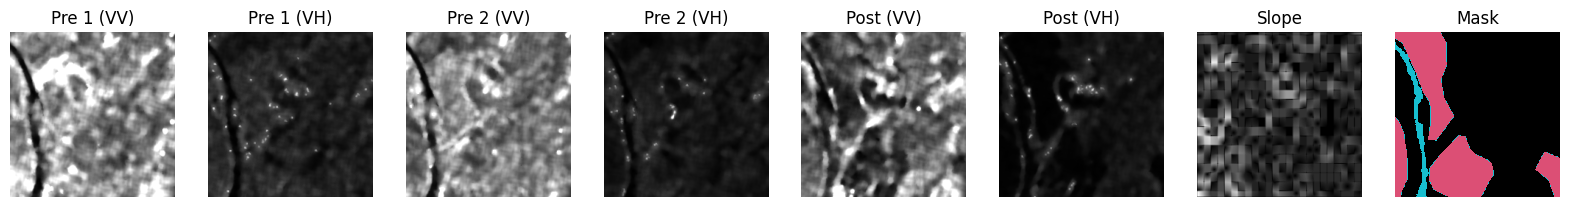

In [18]:
fig, ax = plt.subplots(1, 8, figsize=(20, 8))

cmap =  mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', [(0, 0, 0, 10), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), (0.8647058823529412, 0.30980392156862746, 0.45882352941176474, 1.0), (0.918, 0.929, 0.361, 1.0)], 4)

# First pre-image
img = reverse_scale_img(pre_event_1, torch.tensor(pre1_scale_var_1), torch.tensor(pre1_scale_var_2), configs)
ax[0].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[1].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[0].set_title('Pre 1 (VV)')
ax[1].set_title('Pre 1 (VH)')

# Second pre-image
img = reverse_scale_img(pre_event_2, torch.tensor(pre2_scale_var_1), torch.tensor(pre2_scale_var_2), configs)
ax[2].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[3].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[2].set_title('Pre 2 (VV)')
ax[3].set_title('Pre 2 (VH)')

# Post-image
img = reverse_scale_img(post_event, torch.tensor(post_scale_var_1), torch.tensor(post_scale_var_2), configs)
ax[4].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[5].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[4].set_title('Post (VV)')
ax[5].set_title('Post (VH)')

# SLOPE
img = slope
ax[6].imshow(img.squeeze().cpu().numpy(), cmap='gray')
ax[6].set_title('Slope')

# Mask
img = mask
ax[7].imshow(img.squeeze().cpu().numpy(), cmap=cmap, vmin=0, vmax=3)
ax[7].set_title('Mask')

for i in range(8):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines[['top', 'bottom', 'left', 'right']].set_visible(False)

plt.show()

### SLC Data Loaders

Now let's visualise the SLC data in Kuro Siwo. To get the SLC component instead of the GRD, we have to update the appropriate paths in the configuration files. Note that DEM data are not included in the SLC component.

In [19]:
configs['slc'] = True
configs['train_json'] = '/u/mp005/challenge/KuroSiwo/json/slc_grid_pwater_0.0001.json'
configs['test_json'] = '/u/mp005/challenge/KuroSiwo/json/slc_grid_pwater_0.json'
configs['slc_root_path'] = '/ptmp/mp005/KuroSiwoSLC/'

configs['dem'] = False
configs['slope'] = False
train_loader, val_loader, test_loader = prepare_loaders(configs)

Initializing  RandomEvents
Initializing SLC Dataset
Samples per Climatic zone for mode:  train
{1: 2395, 2: 1216, 3: 11812}
Samples per Activation for mode:  train
{421: 108, 498: 104, 567: 84, 470: 377, 1111010: 333, 497: 386, 267: 256, 174: 28, 147: 211, 1111011: 871, 554: 71, 130: 354, 324: 103, 275: 281, 1111004: 3737, 555: 567, 1111006: 304, 417: 179, 492: 209, 518: 162, 1111005: 489, 502: 196, 273: 109, 427: 772, 496: 23, 118: 49, 1111009: 5060}
Initializing SLC Dataset
Samples per Climatic zone for mode:  val
{1: 88, 2: 2788, 3: 311}
Samples per Activation for mode:  val
{1111003: 22, 279: 2766, 1111008: 39, 437: 169, 520: 142, 559: 49}
Initializing SLC Dataset
Samples per Climatic zone for mode:  test
{1: 1848, 2: 1135, 3: 5457}
Samples per Activation for mode:  test
{561: 88, 562: 82, 1111013: 3905, 1111007: 1321, 1111002: 25, 445: 415, 277: 1899, 321: 384, 205: 143, 411: 178}
Samples in Train Set:  15423
Samples in Val Set:  3187
Samples in Test Set:  8440


In [20]:
batch = train_loader.dataset.__getitem__(1)

In [21]:
post_scale_var_1, post_scale_var_2, post_event, mask, pre1_scale_var_1, \
pre1_scale_var_2, pre_event_1, pre2_scale_var_1, pre2_scale_var_2, pre_event_2, clz, activ = batch

Each SLC patch contains the following channels:
 - `Phase VH`
 - `Phase VV`
 - `Amplitude VH`
 - `Amplitude VV` 

In [22]:
post_event.shape

torch.Size([4, 224, 224])

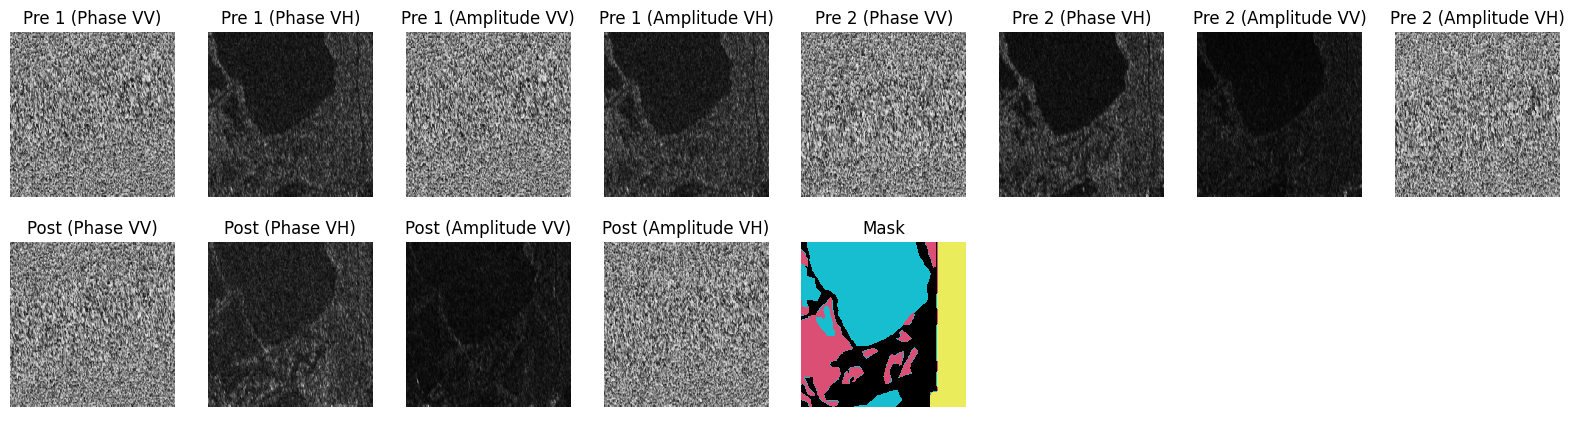

In [23]:
fig, ax = plt.subplots(2, 8, figsize=(20, 5))

cmap =  mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', [(0, 0, 0, 10), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), (0.8647058823529412, 0.30980392156862746, 0.45882352941176474, 1.0), (0.918, 0.929, 0.361, 1.0)], 4)

# First pre-image
img = reverse_scale_img(pre_event_1, torch.tensor(pre1_scale_var_1), torch.tensor(pre1_scale_var_2), configs)
ax[0, 0].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[0, 1].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[0, 2].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[0, 3].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[0, 0].set_title('Pre 1 (Phase VV)')
ax[0, 1].set_title('Pre 1 (Phase VH)')
ax[0, 2].set_title('Pre 1 (Amplitude VV)')
ax[0, 3].set_title('Pre 1 (Amplitude VH)')

# Second pre-image
img = reverse_scale_img(pre_event_2, torch.tensor(pre2_scale_var_1), torch.tensor(pre2_scale_var_2), configs)
ax[0, 4].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[0, 5].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[0, 6].imshow(img[2].cpu().numpy() * 4, cmap='gray')
ax[0, 7].imshow(img[3].cpu().numpy() * 4, cmap='gray')
ax[0, 4].set_title('Pre 2 (Phase VV)')
ax[0, 5].set_title('Pre 2 (Phase VH)')
ax[0, 6].set_title('Pre 2 (Amplitude VV)')
ax[0, 7].set_title('Pre 2 (Amplitude VH)')

# Post-image
img = reverse_scale_img(post_event, torch.tensor(post_scale_var_1), torch.tensor(post_scale_var_2), configs)
ax[1, 0].imshow(img[0].cpu().numpy() * 4, cmap='gray')
ax[1, 1].imshow(img[1].cpu().numpy() * 4, cmap='gray')
ax[1, 2].imshow(img[2].cpu().numpy() * 4, cmap='gray')
ax[1, 3].imshow(img[3].cpu().numpy() * 4, cmap='gray')
ax[1, 0].set_title('Post (Phase VV)')
ax[1, 1].set_title('Post (Phase VH)')
ax[1, 2].set_title('Post (Amplitude VV)')
ax[1, 3].set_title('Post (Amplitude VH)')

# Mask
img = mask
ax[1, 4].imshow(img.squeeze().cpu().numpy(), cmap=cmap, vmin=0, vmax=3)
ax[1, 4].set_title('Mask')

for i in range(2):
    for j in range(8):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].spines[['top', 'bottom', 'left', 'right']].set_visible(False)

plt.show()